AUC: 0.662 | F1: 0.337
              precision    recall  f1-score   support

           0       0.88      0.73      0.80      1609
           1       0.26      0.49      0.34       307

    accuracy                           0.69      1916
   macro avg       0.57      0.61      0.57      1916
weighted avg       0.78      0.69      0.72      1916

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 6, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


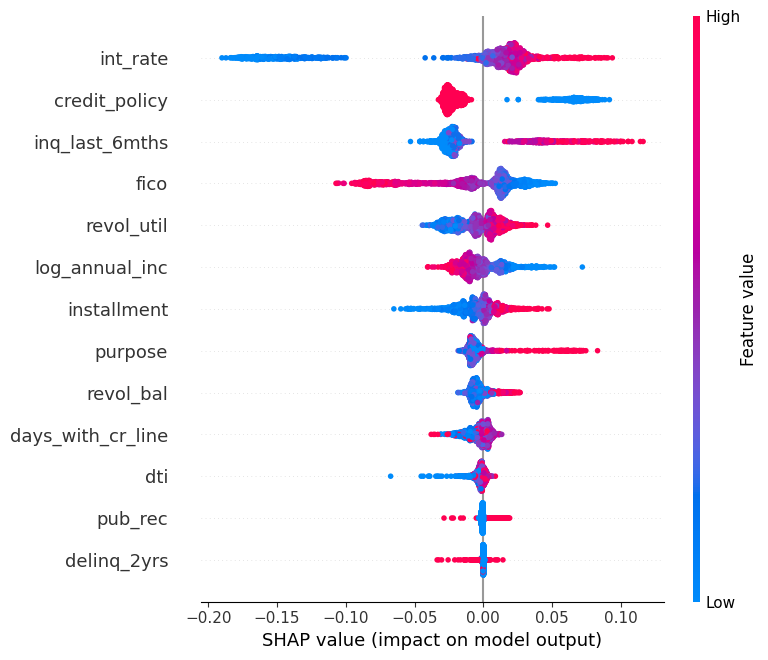

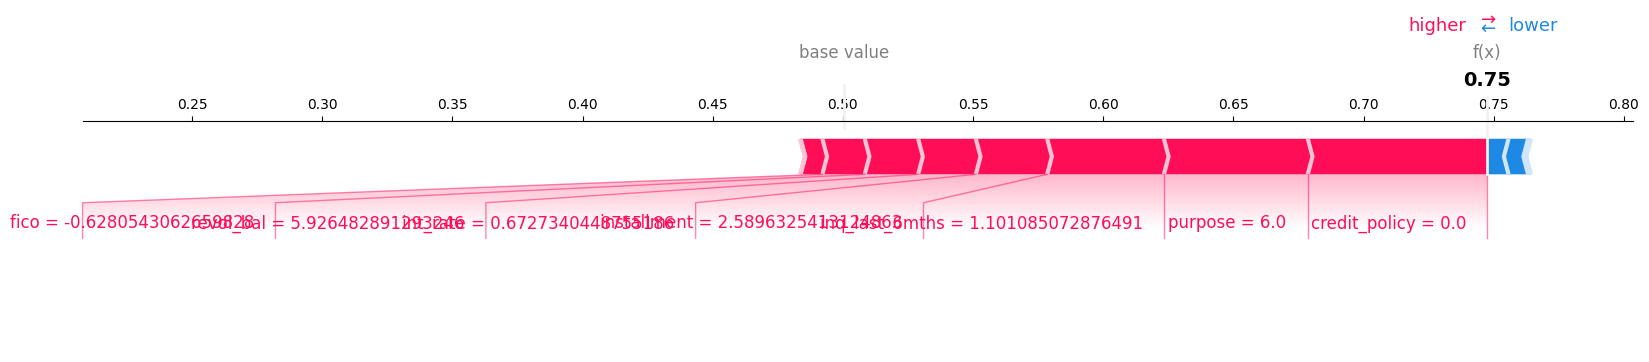

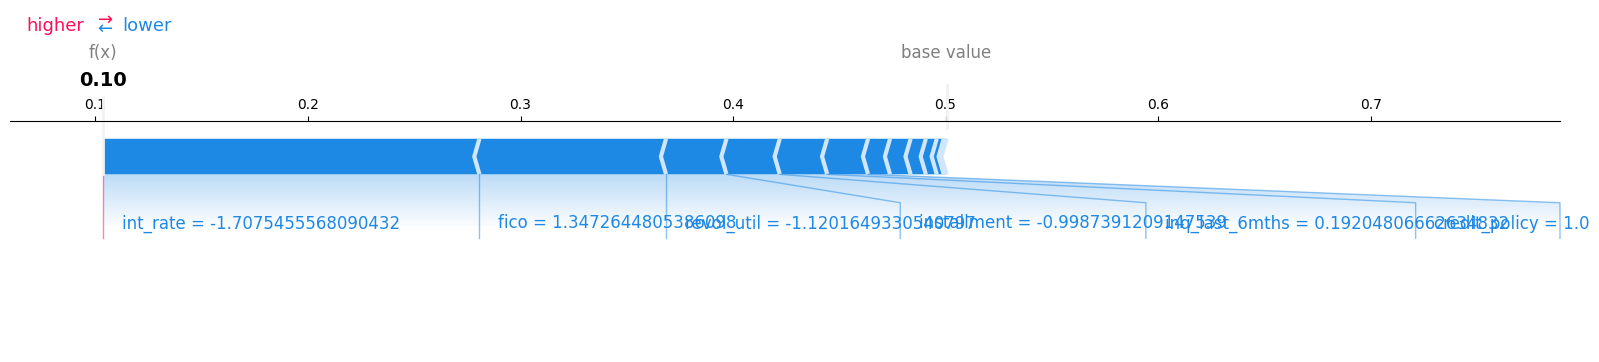

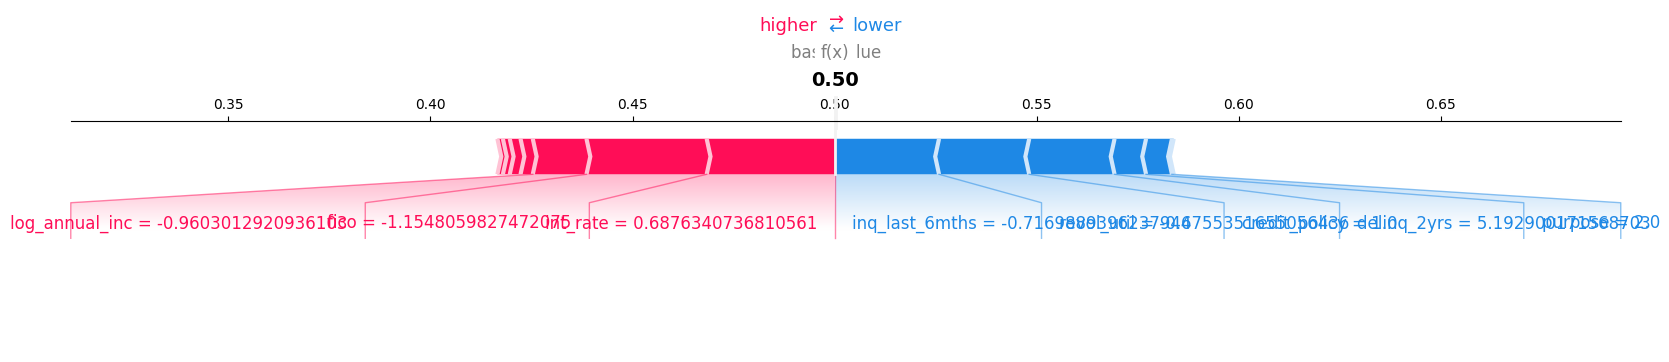

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, f1_score, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
import shap
import matplotlib.pyplot as plt

# --- Step 1: DATA LOADING & CLEANING ---
df = pd.read_csv('/content/loan_data.csv')

# Rename columns for easier reference if needed (manual correction based on dataset preview)
df.columns = ['credit_policy','purpose','int_rate','installment','log_annual_inc','dti',
              'fico','days_with_cr_line','revol_bal','revol_util','inq_last_6mths',
              'delinq_2yrs','pub_rec','not_fully_paid']

# Check missing values & fill/drop as needed
df = df.dropna()

# Encode categorical features
df['purpose'] = LabelEncoder().fit_transform(df['purpose'])

# (Optional) Feature scaling for some models
scaler = StandardScaler()
numerical = ['int_rate','installment','log_annual_inc','dti','fico','days_with_cr_line',
             'revol_bal','revol_util','inq_last_6mths','delinq_2yrs','pub_rec']
df[numerical] = scaler.fit_transform(df[numerical])

# --- Step 2: MODEL TRAINING ---
X = df.drop('not_fully_paid', axis=1)
y = df['not_fully_paid']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)

# Random Forest as an example (swap for XGBClassifier if using XGBoost)
rf = RandomForestClassifier(n_estimators=100, max_depth=6, random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)

# Model metrics
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, y_proba)
f1 = f1_score(y_test, y_pred)
print(f"AUC: {auc:.3f} | F1: {f1:.3f}")
print(classification_report(y_test, y_pred))

# --- Step 3: SHAP GLOBAL INTERPRETATION ---
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)
# Fix: Access SHAP values for the positive class (index 1) across all samples
shap.summary_plot(shap_values[:, :, 1], X_test, show=False)
plt.savefig('shap_summary_plot.png')

# --- Step 4: LOCAL EXPLANATIONS ---
# Sort by model probability for finding high/low/borderline cases
X_test_copy = X_test.copy()
X_test_copy['prob'] = y_proba
X_test_copy['true'] = y_test.values

high_risk = X_test_copy.sort_values('prob', ascending=False).iloc[0, :-2]
low_risk = X_test_copy.sort_values('prob', ascending=True).iloc[0, :-2]
borderline = X_test_copy.iloc[(X_test_copy['prob']-0.5).abs().argsort()[:1]].iloc[0, :-2]

for case, name in zip([high_risk, low_risk, borderline], ['high', 'low', 'border']):
    # Fix: Access SHAP values for the positive class (index 1) for the single sample
    shap.force_plot(explainer.expected_value[1],
                    explainer.shap_values(case.values.reshape(1,-1))[0, :, 1],
                    pd.DataFrame([case]).values,
                    feature_names=X_train.columns, show=False, matplotlib=True)
    plt.savefig(f'shap_force_{name}.png')

# --- Step 5: Model Serialization (as Text) ---
print(rf.get_params())